# Walkthrough of `fingertips_py`

In conjunction with the tutorial on [webscraping and
APIs](../../intermediate-skills-sessions/18-webscraping-apis/index.html),
below is a walkthrough of the `fingertips_py` package maintained by the
Department of Health and Social Care, which simplifies importing data
via the Fingertips API.

## Documentation

[Fingertips Public Health Profiles (public-facing source of the
data)](https://fingertips.phe.org.uk/profiles)

[Fingertips Python API package (fingertips_py)
documentation](https://fingertips-py.readthedocs.io/en/latest/)

[Package repository](https://github.com/DataS-DHSC/fingertips_py)

## Installation

For more information, see the fingertips_py documentation.

Code Club recommends using the uv package management software, but if
you do need to use pip, the relevant installation instructions are
below.

### uv

To install using uv, enter the following in the terminal:

    uv add fingertips_py

### pip

To install using pip, activate your environment and enter the following
in the terminal:

    python -m pip install fingertips_py

## Exploring package functionality

Let’s have a look at the various methods in the package that allow us to
import different levels of the dataset and the metadata.

### Importing the package

We will also use `pandas` for presenting the imported data in a
dataframe.

In [1]:
import fingertips_py as ftp

import pandas as pd

### Get profile IDs by profile name

The profile IDs can be used to refer to different “profiles” on
Fingertips. That is to say, different aspects of public health such as
levels of diabetes, cardiovascular disease, or dementia in the country.

In [2]:
# Cancer profile ID
cancer_profile_md = ftp.metadata.get_profile_by_name('cancer services') # creates a dictionary of metadata. Profile names are not case sensitive.

cancer_profile_id = cancer_profile_md['Id'] # access the profile ID in the metadata dictionary

# Wider Determinants of Health profile ID

wdoh_profile_md = ftp.metadata.get_profile_by_name('wider determinants of health')

wdoh_profile_id = wdoh_profile_md['Id']

# Return the IDs

print(f'Cancer profile ID: {cancer_profile_id}')
print(f'Wider Determinants of Health profile ID: {wdoh_profile_id}')

Cancer profile ID: 92
Wider Determinants of Health profile ID: 130

### Get profile metadata as a dataframe

Inspecting the metadata gives you a lot of information about a given
profile, such as metric sources, definition, and polarity.

In [3]:
wdoh_md_df = ftp.metadata.get_metadata_for_profile_as_dataframe(wdoh_profile_id)

wdoh_md_df.head()

5 rows × 32 columns

### Get metadata by indicator ID

In [4]:
fast_food_md = ftp.get_metadata_for_indicator_as_dataframe(94124)

fast_food_md

1 rows × 32 columns

### Get all area types

This can help you understand which geographical breakdowns are available
via the API. The code below just returns the first 10 so that a large
table doesn’t get displayed on this page, but there are many more. Worth
looking into, if you are planning to make use of these metrics to
support the narrative in a report you are working on.

In [5]:
# returns a nested dictionary, where the area ID is the key to a further dictionary of key:value pairs
all_areas_dict = ftp.metadata.get_all_areas()

# converts the nested dictionary to a DataFrame, where the outer key becomes the index
all_areas_df = pd.DataFrame.from_dict(all_areas_dict, orient='index') 

# reset the DataFrame to have the default indexing
all_areas_df = all_areas_df.reset_index() 

# rename the column labelled 'index' in the dictionary-to-DataFrame conversion
all_areas_df.rename(columns={'index':'Id'}, inplace=True) 

all_areas_df.head(10)

### Get all area types available for a particular profile

In [6]:
wdoh_areas = ftp.metadata.get_area_types_for_profile(wdoh_profile_id)

wdoh_areas_df = pd.DataFrame.from_dict(wdoh_areas, orient='index')

wdoh_areas_df.reset_index(inplace=True)

wdoh_areas_df.drop('index', axis=1,inplace=True) # drop the column called 'index' following the dictionary-to-DataFrame conversion

wdoh_areas_df

### Get all data for indicators

There seems to be an error within this function at time of writing since
it constructs an invalid URL. It has been kept in this demonstration so
that you can be made aware that this method may not work, unless it has
been fixed.

`ftp.retrieve_data.get_all_data_for_indicators`

In [7]:
wdoh_indicators_df = pd.DataFrame(
    ftp.retrieve_data.get_all_data_for_indicators(
        [11404,92772],                  # two Wider Determinants of Health indicators
         502,                           # Area type = Upper tier local authorities
         15,                            # Parent area type =  England
         filter_by_area_codes= None,
         is_test= False
    )
)

wdoh_indicators_df.head()

#### Let’s try this one instead

This one does much the same thing, though slightly differently, while
not causing an error.

`fingertips_py.retrieve_data.get_data_by_indicator_ids`

In [8]:
wdoh_indicators_df = pd.DataFrame(
    ftp.retrieve_data.get_data_by_indicator_ids(
        [11404,92772],                          # two Wider Determinants of Health indicators
         502,                                   # Area type = Upper tier local authorities
         15,                                    # Parent area type =  England
         include_sortable_time_periods=None,
         is_test= False
    )
)

wdoh_indicators_df.head()

5 rows × 27 columns

### Get data at all available geographies for a particular indicator

In [9]:
licensed_premises_all_geographies = ftp.retrieve_data.get_data_for_indicator_at_all_available_geographies(92772)

licensed_premises_all_geographies.head()

5 rows × 27 columns

#### Let’s check whether it has included all geographies by getting a list of unique area types

In [10]:
set(licensed_premises_all_geographies['Area Type'])

{'Counties & UAs (2021/22-2022/23)',
 'Counties & UAs (from Apr 2023)',
 'Districts & UAs (2021/22-2022/23)',
 'Districts & UAs (from Apr 2023)',
 'England',
 'Regions (statistical)'}

### Let’s put all this together and visualise it on a map

We will need to import some more packages:

-   [Geopandas](https://geopandas.org/en/stable/docs.html): supports
    combining geographical data with `pandas` DataFrames.
-   [Contextily](https://contextily.readthedocs.io/en/latest/index.html):
    used for laying maps over geographical shapes, such as maps provided
    by [OpenStreetMap](https://www.openstreetmap.org/about).
-   [Matplotlib](https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html):
    user for applying shading to geographical shapes, adding a legend
    and any other useful chart elements.

In [11]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx

Let’s plot “Child Poverty, Income deprivation affecting children index
(IDACI) 2019 Proportion %” in Bracknell Forest Local Authority area by
MSOA. Let’s imagine we found this metric on the Fingertips website and
want to import the data so that we can create a custom visualisation to
go into some background narrative to a report.

Firstly, we need the profile ID for the Profile “Local health, public
health data for small geographic areas”. Then we can get the profile
metadata as a dataframe so that we can see how the metric we are
interested is referred to within the dataset.

In [12]:
small_geographic_areas_md = ftp.metadata.get_profile_by_name('Local health, public health data for small geographic areas')

# access the profile ID in the metadata dictionary
small_geographic_areas_id = small_geographic_areas_md['Id']

# get a metadata dataframe for the profile in question
small_geographic_areas_md_df = ftp.metadata.get_metadata_for_profile_as_dataframe(small_geographic_areas_id)

# get the indicator ID and name where the name contains "IDACI"
idaci = small_geographic_areas_md_df[['Indicator ID','Indicator']][small_geographic_areas_md_df['Indicator'].str.contains('IDACI')]

# inspect the metrics in our "idaci" variable
idaci

There’s only one indicator with “IDACI” in the name, so we can go ahead
and use the indicator ID to get the data for the metric we are
interested in at MSOA level.

In [13]:
idaci_id = idaci['Indicator ID'].iloc[0] # gets the entry from the Indicator ID column

idaci_df = pd.DataFrame(
    ftp.retrieve_data.get_data_by_indicator_ids(
        idaci_id,
        3, # MSOA
        501 # Local Authority
    )
)

idaci_df.head()

5 rows × 27 columns

Now we can import the data for the geographic mapping. For this we will
use a .geojson boundary shape file downloaded from the [Open Geography
Portal](https://geoportal.statistics.gov.uk/).

In [14]:
gdf = gpd.read_file('data/MSOA_Dec_2011_Boundaries_Super_Generalised_Clipped_BSC_EW_V3_2022_-5254045062471510471.geojson')

gdf.head()

Next, we join it to the Fingertips data so that the metric data and the
geographical data are all in one dataframe.

In [15]:
boundary_df = pd.merge(
    left= gdf,
    right= idaci_df,
    left_on= 'MSOA11CD',
    right_on= 'Area Code',
    how= 'right' 
)

boundary_df = boundary_df[boundary_df['Parent Name'] == 'Bracknell Forest'] # just get data where the parent area (i.e. local authority) is Bracknell Forest

boundary_df.head()

5 rows × 37 columns

Finally, we can plot the data onto OpenStreetMap using the `contextily`
package.

`matplotlib.pyplot` plots the boundary shapes coloured by percentage
using the polygon geometry data from the geopandas dataframe.

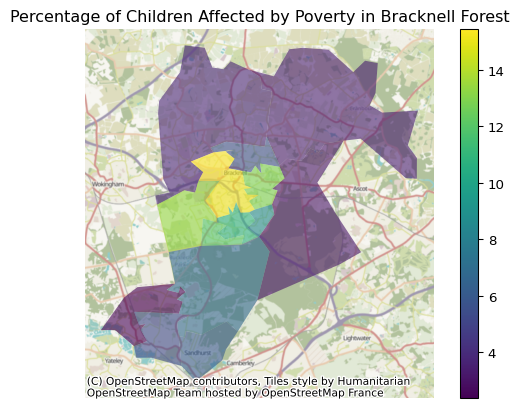

In [16]:
ax = boundary_df.plot(column= 'Value', legend=True, alpha = 0.6)

ax.axis('off')
ax.set_title('Percentage of Children Affected by Poverty in Bracknell Forest')

cx.add_basemap(
    ax,
    crs=boundary_df.crs.to_string()
)